In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import category_encoders as ce
import statsmodels.stats.power as smp
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from collections import Counter
import scipy.stats as stats
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

In [3]:

#data is age	workclass	education	education.num	marital.status	occupation	relationship	race	Gender	capital.gain	capital.loss	hours.per.week	native.country	income	income_value

# clean
df_org = pd.read_csv(r"census_income_original_2.csv")
df = df_org.copy()

# combine net gain and loss
df['capital.loss'] = df['capital.loss'] * -1
df['net_capital'] = df['capital.gain'] + df['capital.loss']
df['net_capital'] = df['net_capital'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

df.drop(columns=['capital.gain', 'capital.loss'], inplace=True)

# encode income
df['income>50k'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)


# handlin income_value missing values
df['income_value'] = pd.to_numeric(df['income_value'], errors='coerce')
df['income_value_encoded'] = np.where(
    (df['income>50k'] == 1) & (df['income_value'] > 50000), 1,
    np.where(
        (df['income>50k'] == 0) & (df['income_value'] <= 50000), -1,
        0 
    )
)
#df = df[~((df['income>50k'] == 1) & (df['income_value'] <= 50000))]

#df.drop(columns=[ 'income', 'income_value'], inplace=True)
#df.drop(columns=[ 'ID', 'native.country', 'education','race'], inplace=True)


# handling missing catigorical variables
cat_cols = ['Gender', 'education.num', 'relationship', 'marital.status', 'occupation', 'income>50k', 'net_capital', 'workclass', 'race', 'income_value_encoded']
cont_col = ['age', 'hours.per.week']
#cat_cols = ['relationship', 'occupation', 'education', 'marital.status', 'workclass']

for col in cat_cols:
    df[col] = df[col].replace('?', np.nan)
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)
#df.drop(columns=[ 'ID', 'education', 'race', 'native.country', 'workclass', 'income', 'income_value'], inplace=True)


#encode gender
mapping = {
    'm': 0,'m ': 0,'M': 0,'malee': 0,'male ': 0,'male': 0,'Male': 0,'Female': 1,'female': 1,'f': 1
}
df['Gender'] = df['Gender'].map(mapping)

#df = pd.get_dummies(df, columns=cat_cols)


# rescale
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['age', 'hours.per.week']])
#df[['age', 'hours.per.week']] = df_scaled


quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42)
#df[['age', 'hours.per.week']] = quantile_transformer.fit_transform(df[['age', 'hours.per.week']])


C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_12412\2759367461.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv(r"census_income_original_2.csv")


C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_12412\1321046167.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=np.nan,inplace=True)


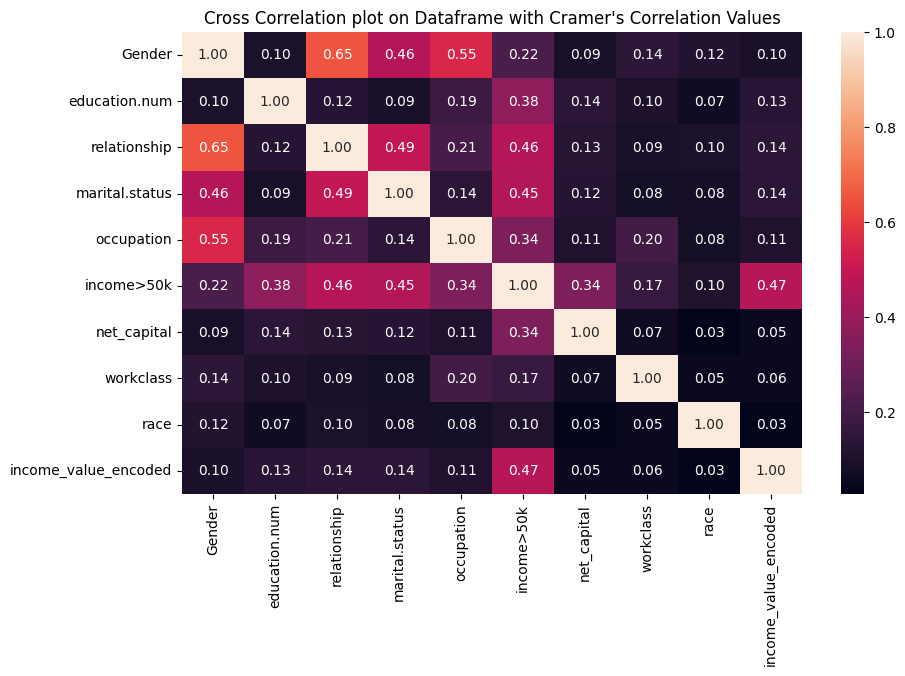

In [4]:
def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    except:
        print("inside error")
        v = 0
    return v
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(10,6))
    sns.heatmap(cramer,annot=True,fmt='.2f')
    plt.title("Cross Correlation plot on Dataframe with Cramer's Correlation Values")
    plt.show()
plot_cramer(df[cat_cols])  

In [12]:
def create_family_status(row):
    if row['marital.status'] == 'Married-civ-spouse':
        return 'Married-with-family' if row['relationship'] in ['Husband', 'Wife'] else 'Married-alone'
        
    if row['marital.status'] == 'Never-married':
        return 'Single-with-family' if row['relationship'] in ['Own-child', 'Other-relative'] else 'Single-alone'
        
    if row['marital.status'] == 'Divorced':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
        
    if row['marital.status'] == 'Widowed':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
        
    if row['marital.status'] == 'Separated':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
    
    return 'Not-in-Family' 

df['family_status'] = df.apply(create_family_status, axis=1)
#df.drop(['marital.status', 'relationship'], axis=1, inplace=True)
cat_cols = ['Gender', 'education.num', 'family_status', 'occupation', 'income>50k', 'net_capital', 'workclass', 'race', 'native.country', 'income_value_encoded']


In [13]:
df['family_status'].value_counts()

family_status
Married-with-family      15328
Single-alone              5655
Single-with-family        5121
Separated-alone           3432
Separated-with-family     3113
Not-in-Family              444
Married-alone              240
Name: count, dtype: int64

Dropping row: ID


C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_12412\1321046167.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=np.nan,inplace=True)


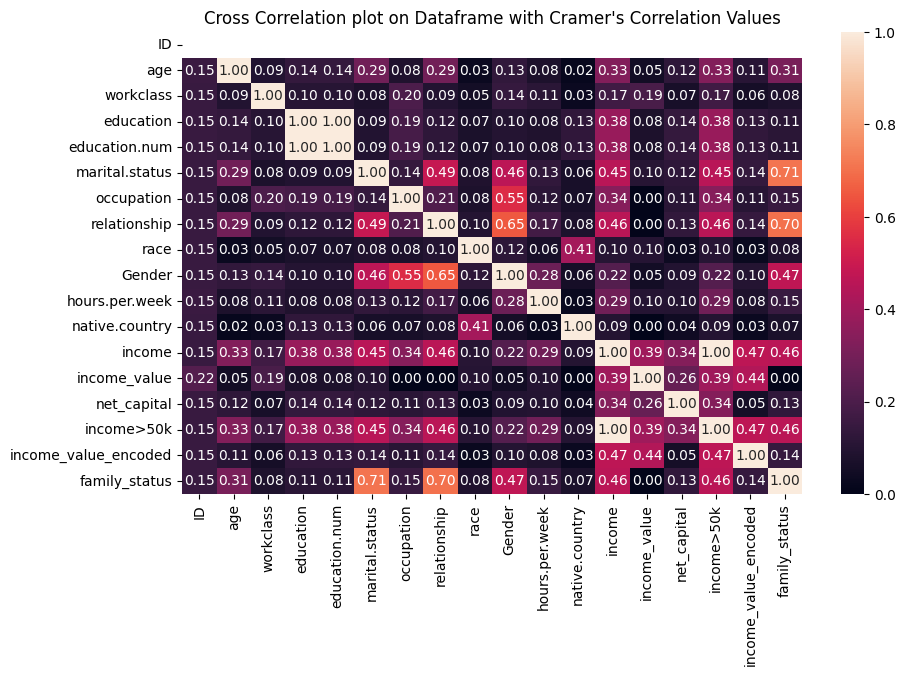

In [14]:
plot_cramer(df)

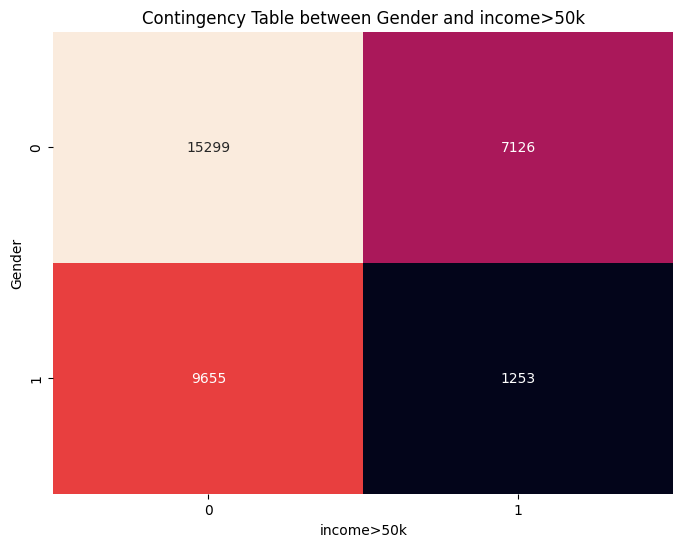

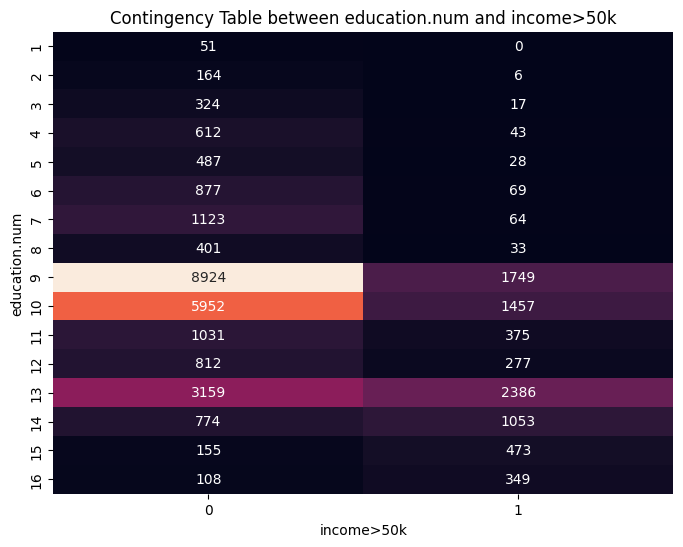

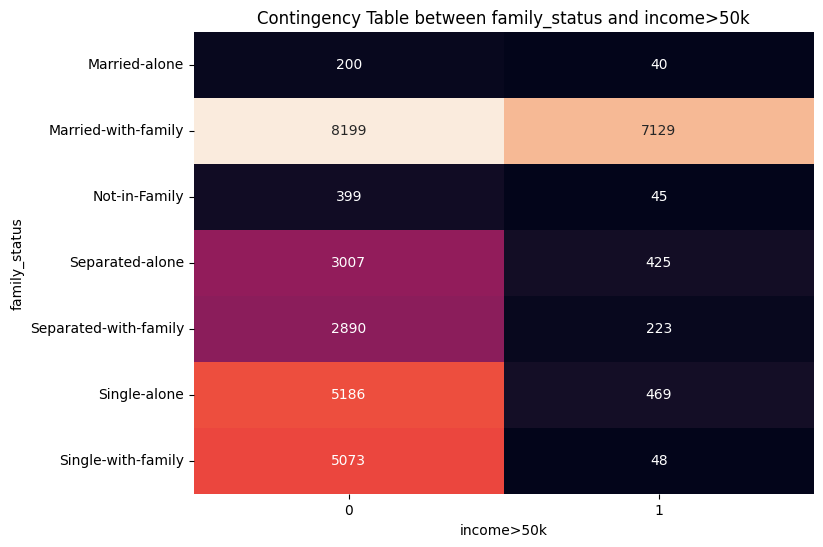

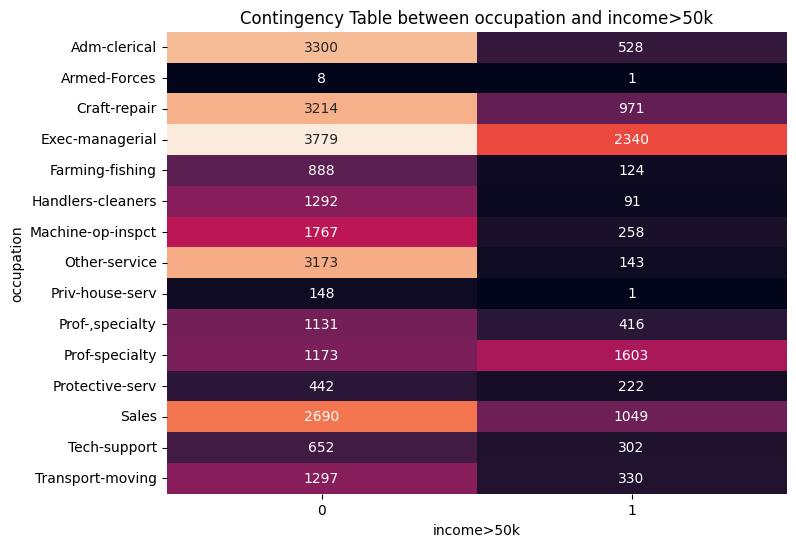

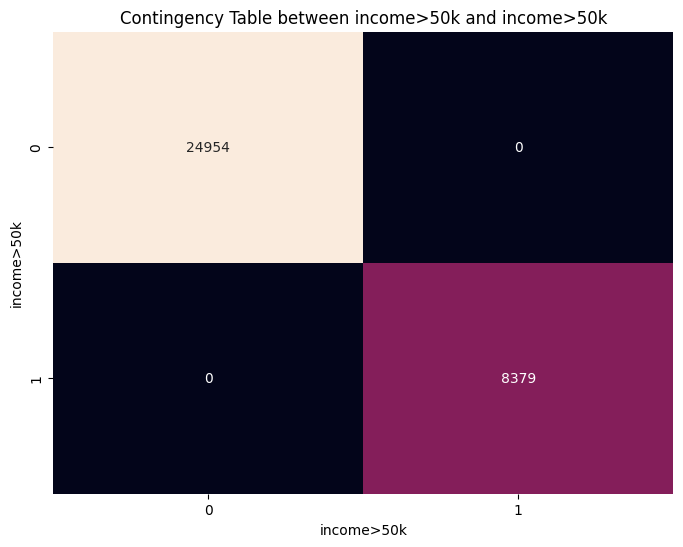

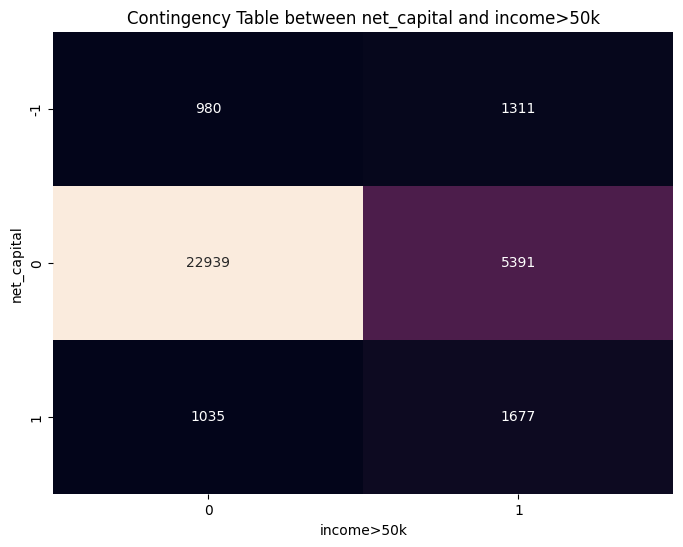

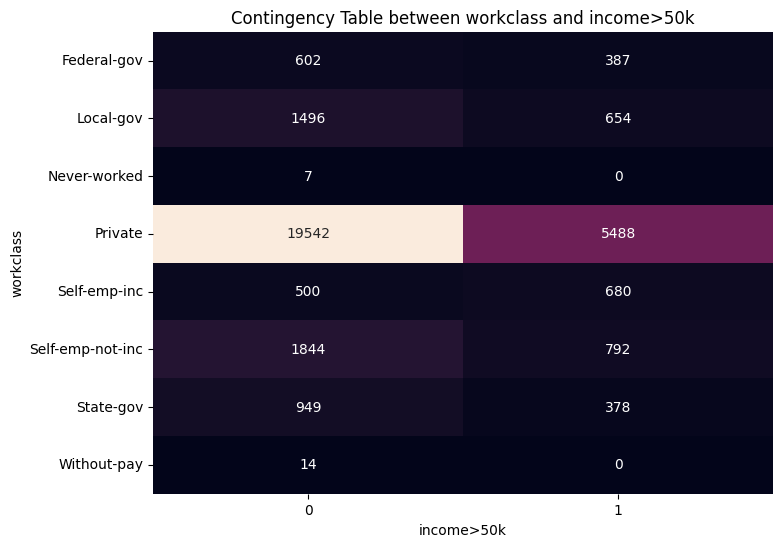

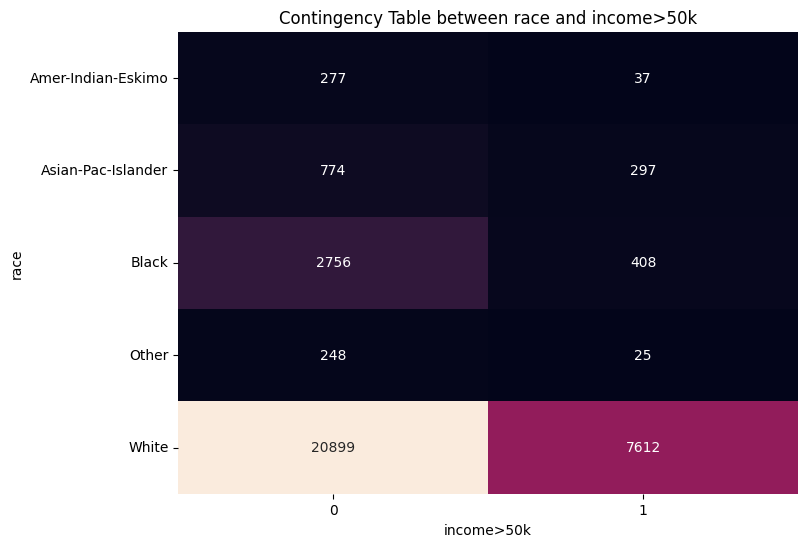

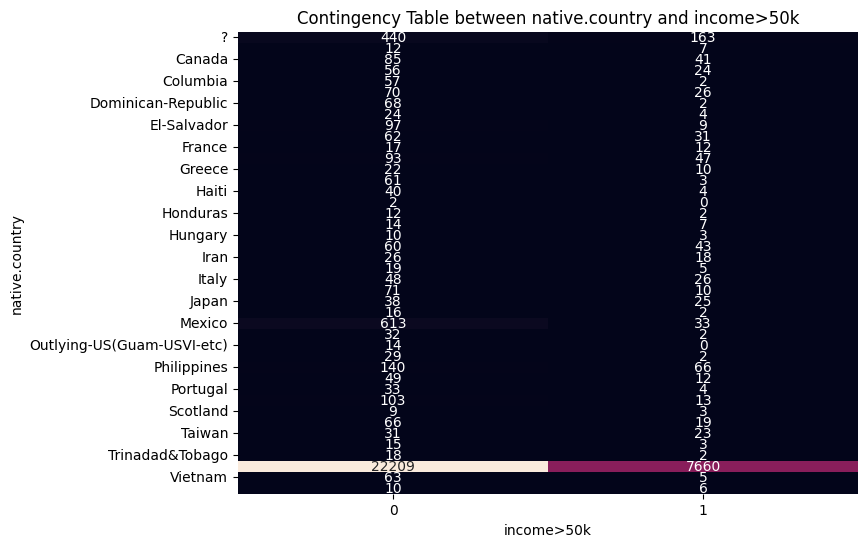

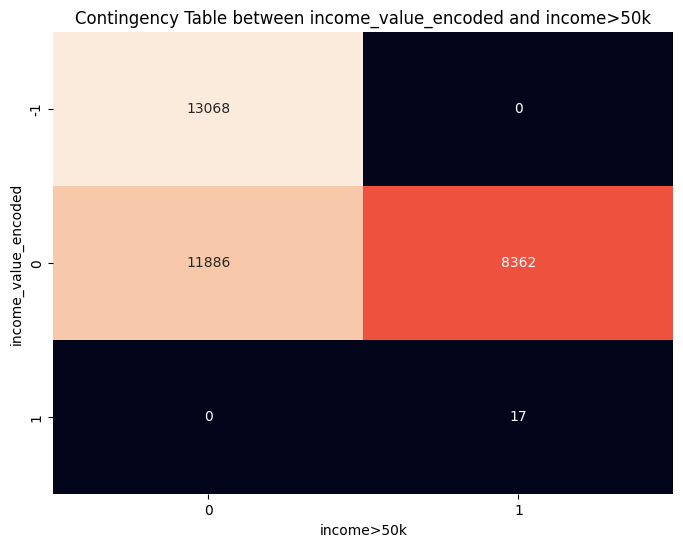

In [15]:
for cat_var in cat_cols:
    contingency_table = pd.crosstab(df[cat_var], df['income>50k'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cbar=False)
    plt.title(f'Contingency Table between {cat_var} and income>50k')
    plt.show()


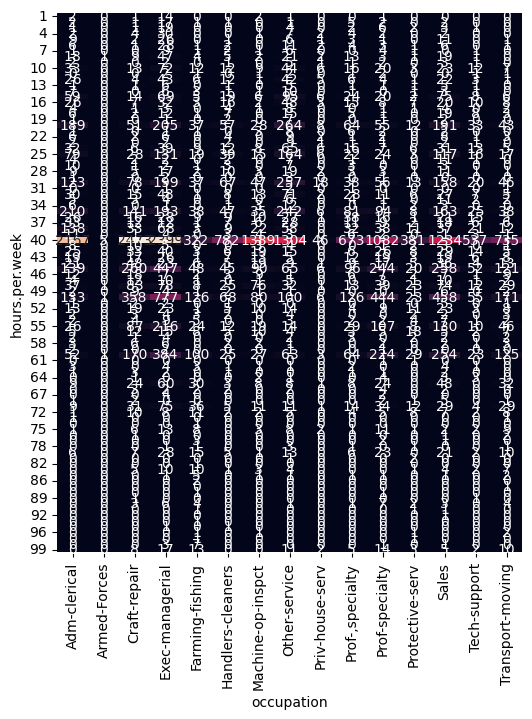

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df['income_value_encoded'] = np.where(
    (df['income_value'].isnull()) | (df['income>50k'].isnull()), 0, 
    np.where(
        (df['income>50k'] == 1) & (df['income_value'] > 50000), 1,
        np.where(
            (df['income>50k'] == 0) & (df['income_value'] <= 50000), -1, 
            -2  
        )
    )
)
# Create the contingency table
contingency_table = pd.crosstab(df['income_value_encoded'], df['income>50k'])
plt.figure(figsize=(6, 7))
sns.heatmap(contingency_table, annot=True, fmt='d', cbar=False)
plt.show()
